12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Plotting confusion matrices...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


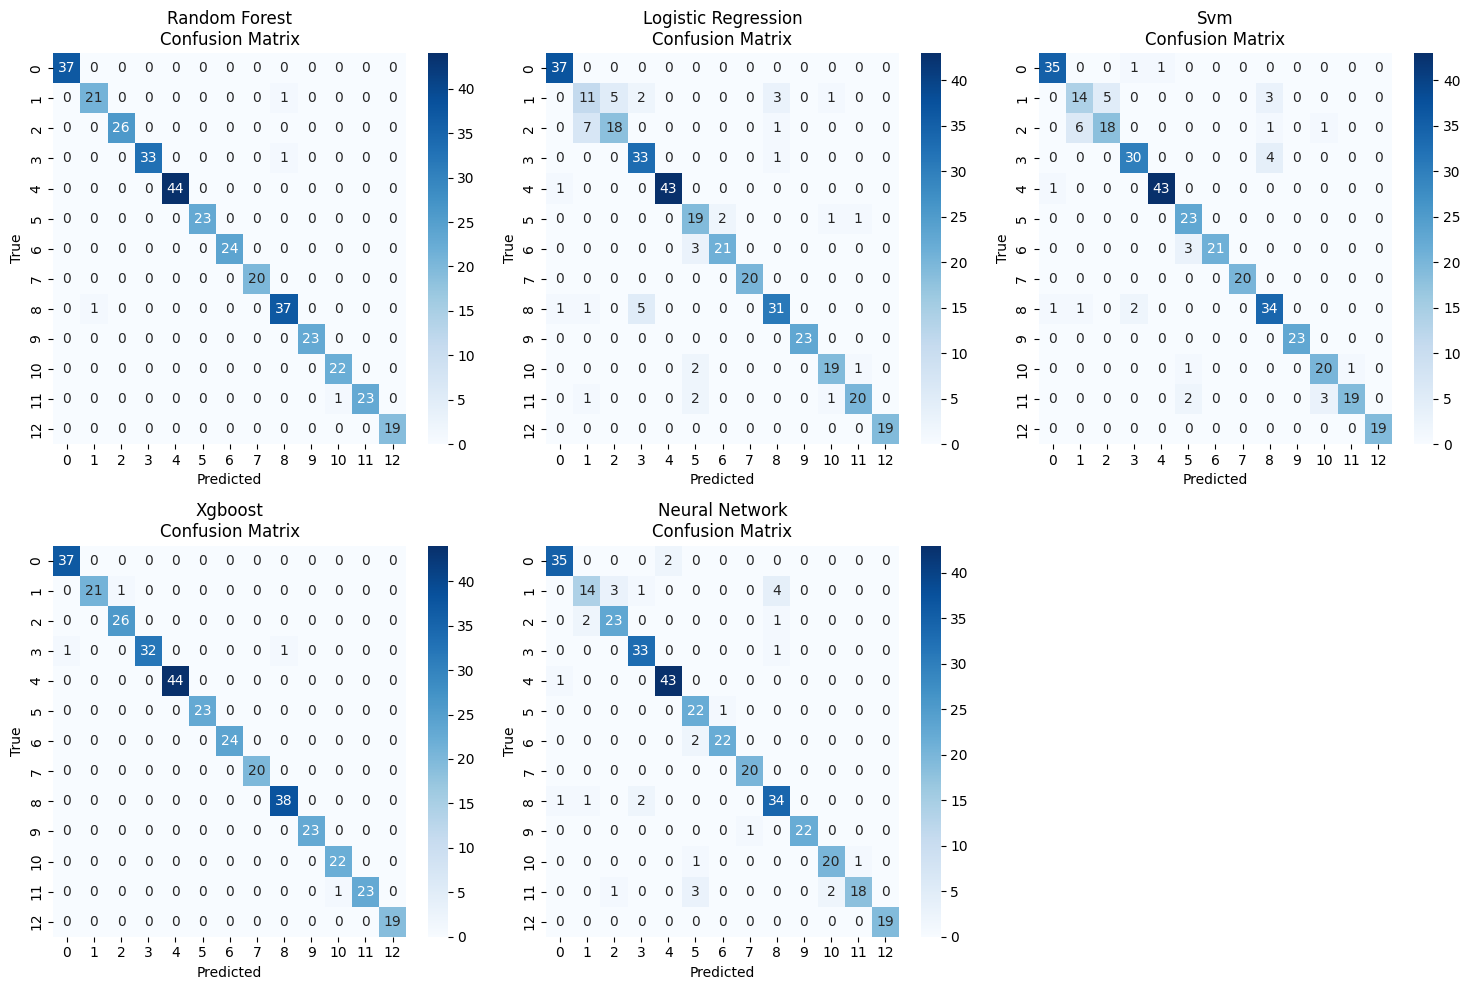


Plotting ROC curves...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


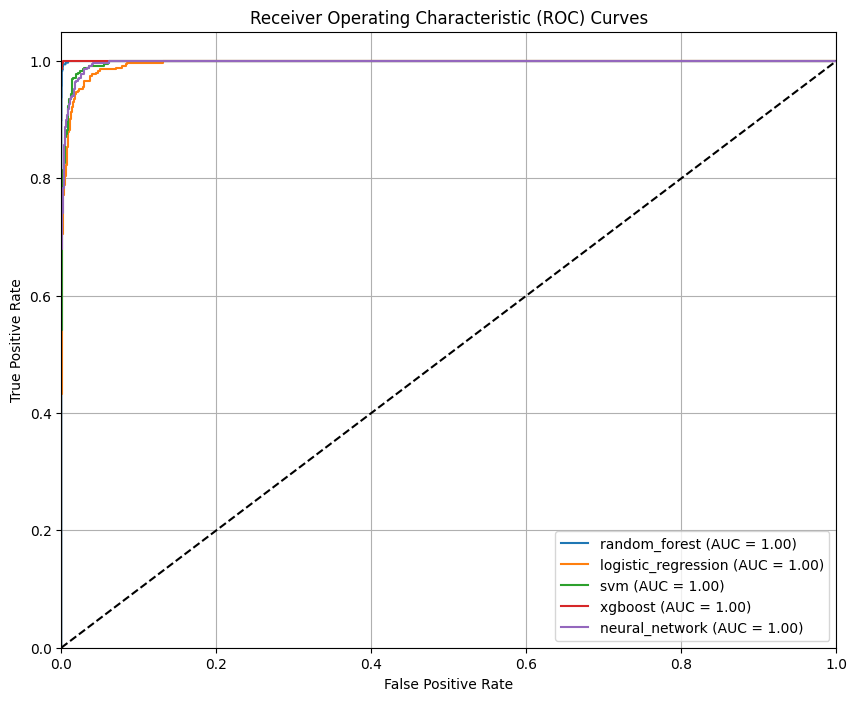


Plotting feature importance for tree-based models...


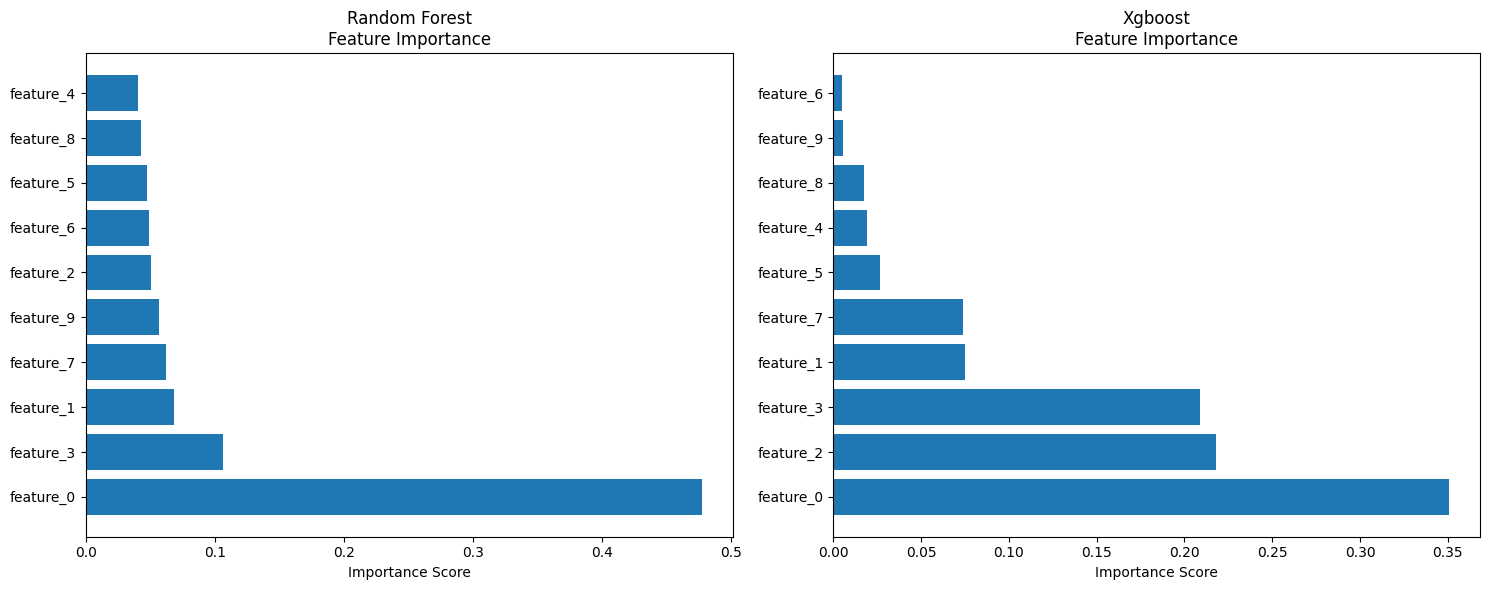


Plotting model comparison metrics...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


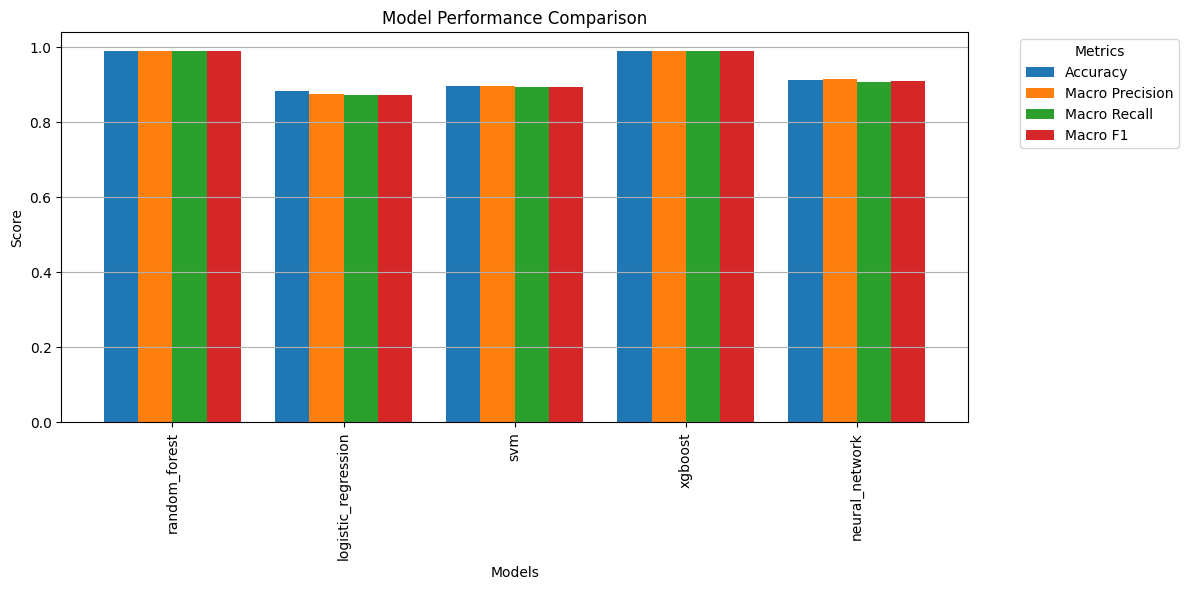


--- Detailed Classification Results ---

Random Forest Classifier:
Accuracy: 0.989
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.95      0.95      0.95        22
           2       1.00      1.00      1.00        26
           3       1.00      0.97      0.99        34
           4       1.00      1.00      1.00        44
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        20
           8       0.95      0.97      0.96        38
           9       1.00      1.00      1.00        23
          10       0.96      1.00      0.98        22
          11       1.00      0.96      0.98        24
          12       1.00      1.00      1.00        19

    accuracy                           0.99       356
   macro avg       0.99      0.99      0.99       356
weighted avg       0.99    

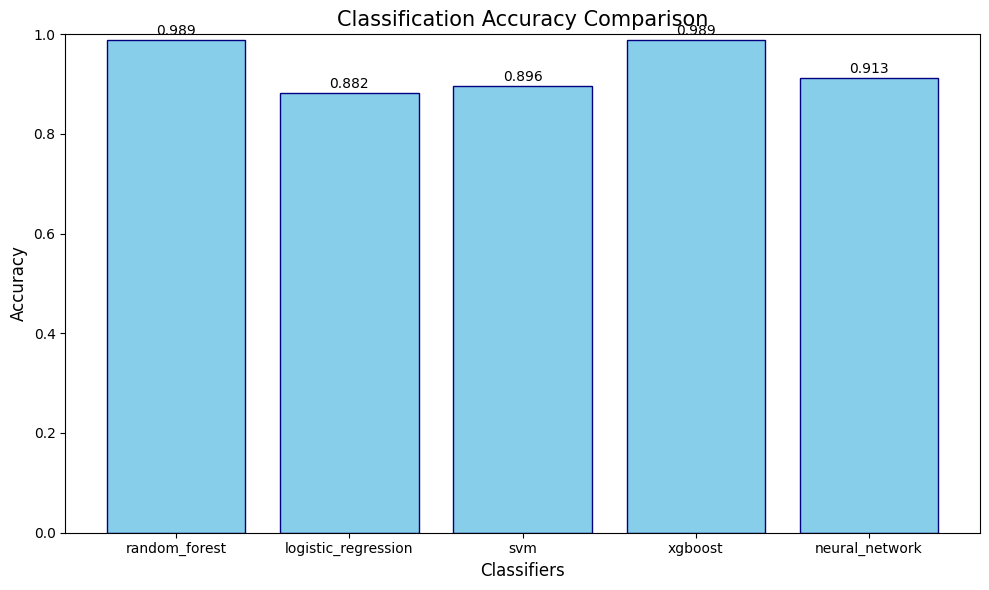


Model weights have been saved in 'model_weights' directory.


In [4]:
import os
import pandas as pd
import numpy as np
import joblib
import pickle
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_confusion_matrices(models_dict, X_test_scaled, y_test_encoded):
    """
    Plot confusion matrices for all models.

    Args:
        models_dict: Dictionary containing trained models
        X_test_scaled: Scaled test features
        y_test_encoded: Encoded test labels
    """
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models_dict.items()):
        if isinstance(model, tf.keras.Model):
            y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
        else:
            y_pred = model.predict(X_test_scaled)

        cm = confusion_matrix(y_test_encoded, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f'{name.replace("_", " ").title()}\nConfusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')

    # Remove any empty subplots
    for idx in range(len(models_dict), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_dict, X_test_scaled, y_test_encoded):
    """
    Plot ROC curves for all models.

    Args:
        models_dict: Dictionary containing trained models
        X_test_scaled: Scaled test features
        y_test_encoded: Encoded test labels
    """
    plt.figure(figsize=(10, 8))

    for name, model in models_dict.items():
        if isinstance(model, tf.keras.Model):
            y_pred_proba = model.predict(X_test_scaled)
        else:
            y_pred_proba = model.predict_proba(X_test_scaled)

        # Handle multi-class ROC
        n_classes = y_pred_proba.shape[1]
        y_test_bin = label_binarize(y_test_encoded, classes=range(n_classes))

        # Calculate ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Calculate micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_feature_importance(models_dict, feature_names):
    """
    Plot feature importance for tree-based models.

    Args:
        models_dict: Dictionary containing trained models
        feature_names: List of feature names
    """
    tree_based_models = {
        name: model for name, model in models_dict.items()
        if isinstance(model, (RandomForestClassifier, xgb.XGBClassifier))
    }

    if not tree_based_models:
        return

    n_models = len(tree_based_models)
    fig, axes = plt.subplots(1, n_models, figsize=(15, 6))
    if n_models == 1:
        axes = [axes]

    for idx, (name, model) in enumerate(tree_based_models.items()):
        if isinstance(model, RandomForestClassifier):
            importances = model.feature_importances_
        else:  # XGBoost
            importances = model.feature_importances_

        # Sort feature importances
        indices = np.argsort(importances)[::-1]

        # Plot
        axes[idx].barh(range(len(indices)), importances[indices])
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels(np.array(feature_names)[indices])
        axes[idx].set_title(f'{name.replace("_", " ").title()}\nFeature Importance')
        axes[idx].set_xlabel('Importance Score')

    plt.tight_layout()
    plt.show()

def plot_model_metrics(models_dict, X_test_scaled, y_test_encoded):
    """
    Plot comprehensive model comparison metrics.

    Args:
        models_dict: Dictionary containing trained models
        X_test_scaled: Scaled test features
        y_test_encoded: Encoded test labels
    """
    metrics = {}

    for name, model in models_dict.items():
        if isinstance(model, tf.keras.Model):
            y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
        else:
            y_pred = model.predict(X_test_scaled)

        report = classification_report(y_test_encoded, y_pred, output_dict=True)
        metrics[name] = {
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1': report['macro avg']['f1-score']
        }

    # Create DataFrame for easy plotting
    metrics_df = pd.DataFrame(metrics).T

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics_df.plot(kind='bar', ax=ax, width=0.8)
    plt.title('Model Performance Comparison')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

def visualize_all_metrics(models_dict, X_test_scaled, y_test_encoded, feature_names):
    """
    Generate all visualizations in sequence.

    Args:
        models_dict: Dictionary containing trained models
        X_test_scaled: Scaled test features
        y_test_encoded: Encoded test labels
        feature_names: List of feature names
    """
    print("Plotting confusion matrices...")
    plot_confusion_matrices(models_dict, X_test_scaled, y_test_encoded)

    print("\nPlotting ROC curves...")
    plot_roc_curves(models_dict, X_test_scaled, y_test_encoded)

    print("\nPlotting feature importance for tree-based models...")
    plot_feature_importance(models_dict, feature_names)

    print("\nPlotting model comparison metrics...")
    plot_model_metrics(models_dict, X_test_scaled, y_test_encoded)


def create_save_directory(base_dir='/content/model_weights'):
    """Create a directory to save model weights."""
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    return base_dir

def save_model_weights(model, model_name, base_dir):
    """
    Save model weights in multiple formats.

    Args:
    - model: Trained model object
    - model_name: Name of the model
    - base_dir: Base directory to save models
    """
    # Ensure save directory exists
    save_path = os.path.join(base_dir, model_name)
    os.makedirs(save_path, exist_ok=True)

    # Saving strategies for different model types
    if isinstance(model, tf.keras.Model):
        # TensorFlow/Keras Model - use new .keras format
        model.save(os.path.join(save_path, f'{model_name}_model.keras'), save_format='keras')

        # Save model weights with correct extension
        weights_path = os.path.join(save_path, f'{model_name}_weights.weights.h5')
        model.save_weights(weights_path)

        # Save model architecture as JSON
        model_json = model.to_json()
        with open(os.path.join(save_path, f'{model_name}_architecture.json'), 'w') as json_file:
            json_file.write(model_json)

    elif isinstance(model, (RandomForestClassifier, LogisticRegression, SVC, xgb.XGBClassifier)):
        # Scikit-learn and XGBoost models
        # Pickle format (most comprehensive)
        with open(os.path.join(save_path, f'{model_name}_pickle.pkl'), 'wb') as f:
            pickle.dump(model, f)

        # Joblib format (more efficient for large numpy arrays)
        joblib.dump(model, os.path.join(save_path, f'{model_name}_joblib.joblib'))

def load_and_preprocess_data(train_path, test_path):
    # Previous implementation remains the same
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    X_train = train_data.drop(['fall', 'label'], axis=1)
    y_train = train_data['label']
    X_test = test_data.drop(['fall', 'label'], axis=1)
    y_test = test_data['label']

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, label_encoder, scaler

def neural_network_classifier(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    # Use Input layer instead of specifying input_shape in first Dense layer
    inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # One-hot encode labels
    y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded)
    y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded)

    outputs = tf.keras.layers.Dense(y_train_onehot.shape[1], activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Suppress TensorFlow logging
    tf.get_logger().setLevel('ERROR')

    model.fit(
        X_train_scaled, y_train_onehot,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )

    y_pred_onehot = model.predict(X_test_scaled)
    y_pred = np.argmax(y_pred_onehot, axis=1)

    return model, y_pred

def run_classifiers(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    # Base directory for saving models
    base_dir = create_save_directory()

    # Dictionary to store classifiers
    classifiers = {
        'random_forest': RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
        'logistic_regression': LogisticRegression(max_iter=1000),
        'svm': SVC(probability=True),
        'xgboost': xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5)
    }

    results = {}
    saved_models = {}

    # Train and save scikit-learn and XGBoost models
    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train_encoded)
        y_pred = clf.predict(X_test_scaled)

        results[name] = {
            'accuracy': accuracy_score(y_test_encoded, y_pred),
            'classification_report': classification_report(y_test_encoded, y_pred)
        }

        # Save model weights
        save_model_weights(clf, name, base_dir)
        saved_models[name] = clf

    # Neural Network (separate handling)
    nn_model, nn_pred = neural_network_classifier(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded)
    results['neural_network'] = {
        'accuracy': accuracy_score(y_test_encoded, nn_pred),
        'classification_report': 'See Neural Network output'
    }

    # Save neural network model
    save_model_weights(nn_model, 'neural_network', base_dir)
    saved_models['neural_network'] = nn_model

    return results, saved_models

def plot_accuracy_comparison(results):
    classifiers = list(results.keys())
    accuracies = [results[clf]['accuracy'] for clf in classifiers]

    plt.figure(figsize=(10, 6))
    plt.bar(classifiers, accuracies, color='skyblue', edgecolor='navy')
    plt.title('Classification Accuracy Comparison', fontsize=15)
    plt.xlabel('Classifiers', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)

    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

def main():
    # Suppress TensorFlow warnings
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    # Load and preprocess data
    X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded, _, _ = load_and_preprocess_data('/content/Train.csv', '/content/Test.csv')

    # Run classifiers and save models
    results, saved_models = run_classifiers(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded)

    # Assuming you have feature names available
    feature_names = X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else [f'feature_{i}' for i in range(X_train_scaled.shape[1])]

    # Generate all visualizations
    visualize_all_metrics(saved_models, X_test_scaled, y_test_encoded, feature_names)

    # Print results and plot comparison
    print("\n--- Detailed Classification Results ---")
    for name, result in results.items():
        print(f"\n{name.replace('_', ' ').title()} Classifier:")
        print(f"Accuracy: {result['accuracy']:.3f}")
        if name != 'neural_network':
            print("Classification Report:", result['classification_report'])

    # Plot accuracy comparison
    plot_accuracy_comparison(results)

    print("\nModel weights have been saved in 'model_weights' directory.")

if __name__ == "__main__":
    main()